In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils import *

from sklearn.ensemble import RandomForestRegressor

In [2]:
def log_od_by_itredirects(data):
    data['log_ODRedirects'] = np.log1p(data['ODRedirects'])

    data['lod_od_by_itredirect'] = data['ItineraryRedirects'] * data['log_ODRedirects']

    return data

def all_preprocessing2(raw_data:pd.DataFrame, columns_to_process:List[str], target_creation_function:Callable, target:str,
                        box_cox_columns:List[str]=False, yeo_johnson_columns:List[str]=False, min_max_scaling:List[str]=False, log_transform_columns:List[str]=False,
                        od_encoding:bool=False, operator_encoding:bool=False,
                        target_func_param1=None, target_func_param2=None, target_func_param3=None):
    """
    This functions completes all feature engineering, target creation and scaling
    RETURNS: updated dataframe and a Class that holds all the scalers


    columns_to_process: what you want it to return, if “daysofweek” it will only return the cosine columns

    target_creation_function: function for making the target, allows for future flexibility

    target = name of the target, this is so no encoders/scalers are looking for it in the new data

    _column variables: the rest is just a list of columns that require different scaling/encoding.

    _encoding: Boolean, True only if you want to encode

    _func_params: Room for adding params to the target creation function.
    """

    #DATA CLEANING

    # All int64 columns need to be float64, or some functions don't work. e.g zscore
    for column in raw_data.select_dtypes(include=['int64']).columns:
        raw_data[column] = raw_data[column].astype('float64')

    #FEATURE ENGINEERING SECTION

    # This creates a column to identify OD's
    raw_data['OD'] = raw_data['OriginCty'] + raw_data['DestinationCty']

    # This calculates the total layover time with ratio
    raw_data['total_layover_time'] = raw_data['DurationMin'] - raw_data['Total_Flight_Duration']
    raw_data['total_layover_time_ratio'] =raw_data['total_layover_time'] /raw_data['DurationMin']

    # This calculates the difference between total distance traveled and 'straight line' distance
    raw_data['extra_travel_distance'] = raw_data['Total_Flight_Distance'] - raw_data['TravelDistanceKm']
    raw_data['extra_travel_distance_ratio'] =  raw_data['Total_Flight_Distance'] / raw_data['TravelDistanceKm']

    # This drops all rows with neg layover time
    data_engineered = drop_neg_layover_time(raw_data)

    # Create the target
    if target_func_param1:
        processed_data = target_creation_function(data_engineered, target_func_param1, target_func_param2, target_func_param3)
    else:
        processed_data = target_creation_function(data_engineered)

    # Seperating target so encoders dont store a df shape that is larger than real-world data
    # This is so encoders do not expect the extra column when running on new data, which will not have a target
    y = processed_data[target]

    model_data = processed_data.drop(columns=[target])

    #BINARY ENCODING
    # Binary encoding origin and destination
    if od_encoding:
        o_encoder = ce.BinaryEncoder()
        origin_apt_encoded = o_encoder.fit_transform(model_data['OriginApt'])
        columns_to_process.extend(origin_apt_encoded.columns.to_list())

        d_encoder = ce.BinaryEncoder()
        destination_apt_encoded = d_encoder.fit_transform(model_data['DestinationApt'])
        columns_to_process.extend(destination_apt_encoded.columns.to_list())

        #Concatinating newly encoded columns
        origin_binary = pd.concat([model_data, origin_apt_encoded], axis=1)
        dest_binary = pd.concat([origin_binary, destination_apt_encoded], axis=1)
    else:
        o_encoder = None
        d_encoder = None
        dest_binary = model_data.copy()

    # Binary encoding Operator IATA'
    if operator_encoding:
        seg_0_encoder = ce.BinaryEncoder()
        seg_0_binary = seg_0_encoder.fit_transform(model_data['Seg_0_OperatingCarrierIATA'])
        columns_to_process.extend(seg_0_binary.columns.to_list())

        seg_1_encoder = ce.BinaryEncoder()
        seg_1_binary = seg_1_encoder.fit_transform(model_data['Seg_1_OperatingCarrierIATA'])
        columns_to_process.extend(seg_1_binary.columns.to_list())

        seg_2_encoder = ce.BinaryEncoder()
        seg_2_binary = seg_2_encoder.fit_transform(model_data['Seg_2_OperatingCarrierIATA'])
        columns_to_process.extend(seg_2_binary.columns.to_list())

        seg_3_encoder = ce.BinaryEncoder()
        seg_3_binary = seg_3_encoder.fit_transform(model_data['Seg_3_OperatingCarrierIATA'])
        columns_to_process.extend(seg_3_binary.columns.to_list())

        #Concatinating newly encoded columns
        seg0_bin = pd.concat([dest_binary, seg_0_binary], axis=1)
        seg1_bin = pd.concat([seg0_bin, seg_1_binary], axis=1)
        seg2_bin = pd.concat([seg1_bin, seg_2_binary], axis=1)
        all_binary = pd.concat([seg2_bin, seg_3_binary], axis=1)
    else:
        seg_0_encoder = None
        seg_1_encoder = None
        seg_2_encoder = None
        seg_3_encoder = None
        all_binary = dest_binary.copy()

    all_binary = all_binary[columns_to_process]

    #SCALING
    # Box cox

    # Dictionary to store best_lambda per column for new data processing
    box_lambdas = {}

    if box_cox_columns:
        for col in box_cox_columns:
            all_binary[col], box_lambda = stats.boxcox(all_binary[col])
            box_lambdas[col] = box_lambda

    # Yeo-johnson
    # Dictionary to store best_lambda per column for new data processing
    yeo_lambdas = {}

    if yeo_johnson_columns:
        for col in yeo_johnson_columns:
            all_binary[col], yeo_lambda = stats.yeojohnson(all_binary[col])
            yeo_lambdas[col] = yeo_lambda

    # Log transformations
    if log_transform_columns:
        for column in log_transform_columns:
            all_binary.loc[:, column] = np.log1p(model_data[column])

    #Min max scaling
    # Dictionary to store min max scaler per column for new data processing
    min_max_scalers = {}

    if min_max_scaling:
        for col in min_max_scaling:
            minmax_scaler = MinMaxScaler()
            all_binary[col] = minmax_scaler.fit_transform(all_binary[[col]])
            min_max_scalers[col] = minmax_scaler


    if 'dayofweek' in columns_to_process:
        # Cyclical encoding
        all_binary['sin_day'] = np.sin(2 * np.pi * all_binary['dayofweek'] / 7)
        all_binary['cos_day'] = np.cos(2 * np.pi * all_binary['dayofweek'] / 7)

        all_binary.drop(columns='dayofweek', inplace=True)

    if 'SelfTransfer' in columns_to_process:
        #Inversing the importance of SelfTransfer, so Non Self Transfer is seen as better by the model
        all_binary['SelfTransfer'] = all_binary['SelfTransfer'].apply(convert_bool_to_num)

    #STORING SCALERS
    class PreprocessScalers:
        def __init__(self, o_encoder, d_encoder, box_lambdas, yeo_lambdas, min_max_scalers,seg_0_encoder, seg_1_encoder, seg_2_encoder, seg_3_encoder):
                self.o_encoder = o_encoder
                self.d_encoder = d_encoder
                self.box_lambda = box_lambdas
                self.yeo_lambda = yeo_lambdas
                self.minmax_scaler = min_max_scalers
                self.seg_0_encoder = seg_0_encoder
                self.seg_1_encoder = seg_1_encoder
                self.seg_2_encoder = seg_2_encoder
                self.seg_3_encoder = seg_3_encoder

    scalers = PreprocessScalers(o_encoder, d_encoder, box_lambdas, yeo_lambdas, min_max_scalers, seg_0_encoder, seg_1_encoder, seg_2_encoder, seg_3_encoder)

    #Adding y into dataset
    all_binary[target] = y

    # Returning dataframe and scalers
    return all_binary, scalers

In [3]:
columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']


In [4]:
data = pd.read_csv('../raw_data/skyscanner_data_171223')

no_nan = data.dropna(subset=['OriginApt', 'DestinationApt', 'DurationMin', 'PricePerPax', 'DestinationCtry'])

economy_flights = no_nan[(no_nan['PricePerPax'] > 0) & (no_nan['PricePerPax'] < 2000)]

distance_makes_sense_flights = economy_flights[(economy_flights["TravelDistanceKm"]<= economy_flights["Total_Flight_Distance"]) &
                                               (economy_flights["Total_Flight_Distance"] <= 5*economy_flights["TravelDistanceKm"])]

processed_data, scalers = all_preprocessing2(distance_makes_sense_flights,columns, log_od_by_itredirects, 'lod_od_by_itredirect', box_cox, yeo_johnson)

# processed_data, scalers = all_preprocessing(distance_makes_sense_flights,columns, scale_itin_redirects, 'Score_Z_score_0_50', box_cox, yeo_johnson,
#                                    target_func_param1='ItineraryRedirects', target_func_param2=0, target_func_param3=50)

/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_14705/416396389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[column] = raw_data[column].astype('float64')
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_14705/416396389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[column] = raw_data[column].astype('float64')
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_14705/416396389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

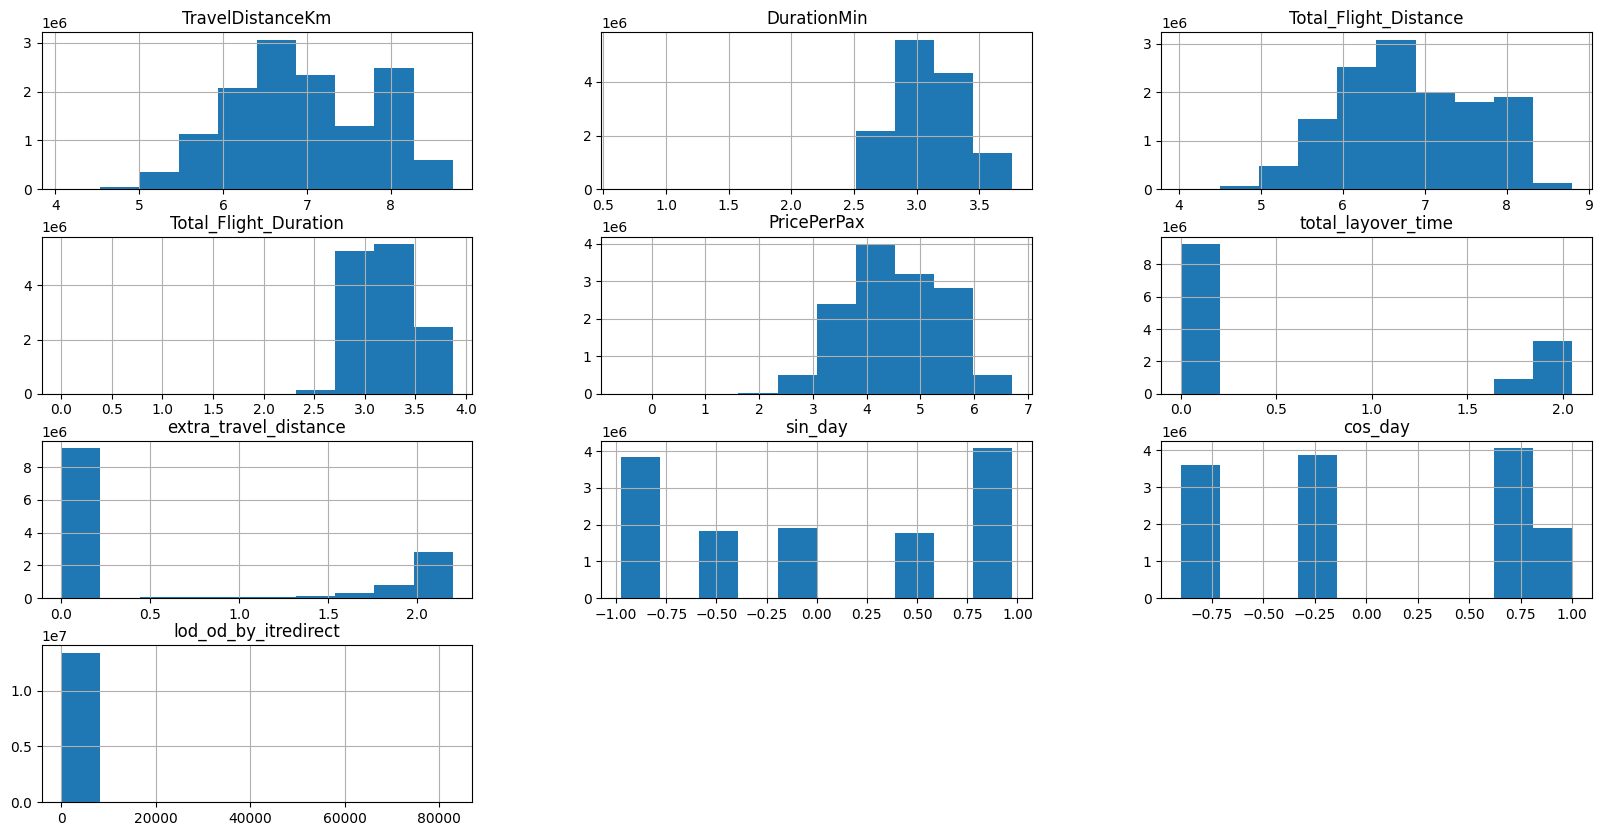

In [5]:
processed_data.hist(figsize=(20, 10));

In [6]:
clean_processed_data = processed_data.dropna(subset=['lod_od_by_itredirect'])

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(clean_processed_data.drop('Score_Z_score_0_50', axis=1),
#                                                     clean_processed_data['Score_Z_score_0_50'], test_size=0.2, random_state=42)

In [8]:
def process_new_data2(original_data:pd.DataFrame, new_data:pd.DataFrame, scalers, colums_to_keep:List[str],
                     box_cox_columns:List[str]=False, yeo_johnson_columns:List[str]=False, log_transform_columns:List[str]=False, min_max_columns:List[str]=False,
                     od_encoding:bool=False, operator_encoding:bool=False):
    """
    This function processes new data, using scalers and encoders from the training set
    It only returns the columns stated in columns_to_keep, and encoded columns if those options flipped to True

    original_data: This is used for encoding - can have dummy data if no encoding is taking place.

    new_data: The data you are processing

    scalers: Must be a Class variable of scalers from the all_preprocessing function

    columns_to_keep: this is the list of columns you want to keep, if daysofweek, it only returns the cosin columns and drops daysofweek

    _columns variables: List of columns you want in that scaling step

    od_encoding + operator_encoding: Boolean, only flip if you want to encode new data.
    """

    # DATA CLEANING

    # Filling the Null itinerary_fare data with booked_fare
    new_data['itinerary_fare'].fillna(new_data['booked_fare'], inplace=True)

    # Dropping data where itinerary_fare remains Null
    clean_data = new_data.dropna(subset=['itinerary_fare']).copy().reset_index()

    # FEATURE ENGINEERING
    clean_data['DurationMin'] = clean_data['flight_time'] + clean_data['connection_time']

    clean_data['total_layover_time_ratio'] = clean_data['connection_time'] / clean_data['DurationMin']

    clean_data['extra_travel_distance'] = clean_data['total_distance'] - clean_data['direct_distance']
    clean_data['extra_travel_distance_ratio'] =  clean_data['total_distance'] / clean_data['direct_distance']

    if 'seg_0' not in clean_data.columns:
        clean_data['seg_0'] = 0
        clean_data['seg_1'] = 0

        for i in range(len(clean_data)):
            listtt = clean_data['flights'][i].split(',')
            clean_data['seg_0'][i] = listtt[0][:2]
            clean_data['seg_1'][i] = listtt[1].strip()[:2]

    # Renaming the columns
    col_rename_dict = {'origin': 'OriginApt', 'destination':'DestinationApt', 'days_to_travel':'TravelHorizonDays', 'total_distance':'Total_Flight_Distance',
                    'direct_distance':'TravelDistanceKm', 'connection_time':'total_layover_time', 'flight_time':'Total_Flight_Duration','itinerary_fare':'PricePerPax',
                    'seg_0':'Seg_0_OperatingCarrierIATA', 'seg_1':'Seg_1_OperatingCarrierIATA', 'seg_2':'Seg_2_OperatingCarrierIATA', 'seg_3':'Seg_3_OperatingCarrierIATA'}

    clean_data = clean_data.rename(columns=col_rename_dict).copy()

    #TEMP creating Stops and SelfTransfer data
    clean_data['Stops'] = 1
    clean_data['SelfTransfer'] = True

    #DATA CLEANING
    for column in clean_data.select_dtypes(include=['int64']).columns:
        clean_data[column] = clean_data[column].astype('float64')

    # ENCODING
    if od_encoding:
        #Binary encoding origin
        origin_encoded = encoding_new_data(original_data=original_data, data_to_be_processed=clean_data, column='OriginApt', encoder=scalers.o_encoder)

        # Binary encoding Destination
        destination_encoded = encoding_new_data(original_data, clean_data, 'DestinationApt', scalers.d_encoder)

        # Updating the dataset with the encoded columns
        clean_data = pd.concat([clean_data, origin_encoded, destination_encoded], axis=1)

        # Ensuring the columns are returned at the end of the function
        colums_to_keep.extend(origin_encoded.columns.to_list())
        colums_to_keep.extend(destination_encoded.columns.to_list())

    if operator_encoding:
        seg_0_op_iata = encoding_new_data(original_data, clean_data, 'Seg_0_OperatingCarrierIATA', scalers.seg_0_encoder)
        seg_1_op_iata = encoding_new_data(original_data, clean_data, 'Seg_1_OperatingCarrierIATA', scalers.seg_1_encoder)

        if 'Seg_2_OperatingCarrierIATA' in clean_data.columns:
            seg_2_op_iata = encoding_new_data(original_data, clean_data, 'Seg_2_OperatingCarrierIATA', scalers.seg_2_encoder)
        else:
            seg_2_op_iata = False

        if 'Seg_3_OperatingCarrierIATA' in clean_data.columns:
            seg_3_op_iata = encoding_new_data(original_data, clean_data, 'Seg_3_OperatingCarrierIATA', scalers.seg_3_encoder)
        else:
            seg_3_op_iata = False

        # Updating the dataset with the encoded columns

        dfs_to_concat = [clean_data, seg_0_op_iata, seg_1_op_iata]

        if seg_2_op_iata:
            dfs_to_concat.append(seg_2_op_iata)
        if seg_3_op_iata:
            dfs_to_concat.append(seg_3_op_iata)

        clean_data = pd.concat(dfs_to_concat, axis=1)

        # Ensuring the columns are returned at the end of the function
        if operator_encoding:
            colums_to_keep.extend(seg_0_op_iata.columns.to_list())
            colums_to_keep.extend(seg_1_op_iata.columns.to_list())
            if seg_2_op_iata:
                colums_to_keep.extend(seg_2_op_iata.columns.to_list())
            if seg_3_op_iata:
                colums_to_keep.extend(seg_3_op_iata.columns.to_list())

    colums_to_keep.append('bookings')

    # SCALING
    # Box cox
    if box_cox_columns:
        for col in box_cox_columns:
            clean_data.loc[:,col]  = stats.boxcox(clean_data[col], lmbda=scalers.box_lambda[col])

    # Yeo-johnson
    if yeo_johnson_columns:
        for col in yeo_johnson_columns:
            clean_data.loc[:,col] = stats.yeojohnson(clean_data[col], lmbda=scalers.yeo_lambda[col])

    # Log transformations
    if log_transform_columns:
        for col in log_transform_columns:
            clean_data.loc[:,col] = np.log1p(clean_data[col])

    #Min max scaling
    if min_max_columns:
        for col in min_max_columns:
            clean_data.loc[:,col] = scalers.minmax_scaler[col].transform(clean_data[[col]])

    if 'SelfTransfer' in colums_to_keep:
        #Inversing the importance of SelfTransfer, so Non Self Transfer is seen as better by the model
        clean_data['SelfTransfer'] = clean_data['SelfTransfer'].apply(convert_bool_to_num)

    data_to_return = clean_data[colums_to_keep].copy()

    if 'dayofweek' in colums_to_keep:
        # Cyclical encoding
        data_to_return['sin_day'] = np.sin(2 * np.pi * data_to_return['dayofweek'] / 7)
        data_to_return['cos_day'] = np.cos(2 * np.pi * data_to_return['dayofweek'] / 7)

        # Dropping day of week as it is no longer neccesary
        data_to_return = data_to_return.drop(columns=['dayofweek']).copy()

    return data_to_return


In [9]:
dohop_data = pd.read_csv('../raw_data/OptiFlyAI_testset.csv')
processed_dohop = process_new_data2(original_data=clean_processed_data, new_data=dohop_data, scalers=scalers,
                 colums_to_keep=columns, box_cox_columns=box_cox, yeo_johnson_columns=yeo_johnson)

/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_14705/3753027783.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['seg_0'][i] = listtt[0][:2]
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_14705/3753027783.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'U2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clean_data['seg_0'][i] = listtt[0][:2]
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_14705/3753027783.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [10]:
processed_dohop.columns

Index(['TravelDistanceKm', 'DurationMin', 'Total_Flight_Distance',
       'Total_Flight_Duration', 'PricePerPax', 'total_layover_time',
       'extra_travel_distance', 'bookings', 'sin_day', 'cos_day'],
      dtype='object')

In [11]:
clean_processed_data. columns

Index(['TravelDistanceKm', 'DurationMin', 'Total_Flight_Distance',
       'Total_Flight_Duration', 'PricePerPax', 'total_layover_time',
       'extra_travel_distance', 'sin_day', 'cos_day', 'lod_od_by_itredirect'],
      dtype='object')

# Random forrest Model

In [12]:
def evaluate_model(data, model):
    data["predicted_score"] = model.predict(data.drop('bookings', axis=1)).flatten()

    # Create a new colummn bucketed into "booked" and "not-booked"
    data["status"] = np.where(data["bookings"] > 0, "booked", "not-booked")

    # Filter down the dataset to those rows which were booked
    booked_data = data[data["status"] == "booked"]

    # Filter down the dataset to those rows which were not booked
    not_booked_data = data[data["status"] == "not-booked"]

    # Compute minimum score threshold for booked and not-booked data
    min_booked_score = data.loc[data["status"] == "booked", "predicted_score"].min()
    min_not_booked_score = data.loc[data["status"] == "not-booked", "predicted_score"].min()

    # Check for the edge case and issue a warning, if it applies
    if min_booked_score < min_not_booked_score:
        return "Edge case encountered: Min score of booked rows is lower than min score of not-booked rows."

    metrics = {"min_threshold": min_booked_score,
               "total_rows": data.shape[0],
               "TP": booked_data[data["predicted_score"] >= min_booked_score].shape[0],
               "FP": not_booked_data[data["predicted_score"] >= min_booked_score].shape[0],
               "TN": not_booked_data[data["predicted_score"] < min_booked_score].shape[0],
               "FN": booked_data[data["predicted_score"] < min_booked_score].shape[0],
               }

    return metrics

In [21]:
forrest = RandomForestRegressor(n_estimators=150, criterion="poisson", max_depth=12, n_jobs=-1)
forrest.fit(clean_processed_data.drop('lod_od_by_itredirect', axis=1), clean_processed_data['lod_od_by_itredirect'])

RandomForestRegressor(criterion='poisson', max_depth=12, n_estimators=150,
                      n_jobs=-1)

In [29]:
feats = clean_processed_data.drop('lod_od_by_itredirect', axis=1).columns.to_list()

In [30]:
df = pd.DataFrame(index=feats)
df['importance'] = forrest.feature_importances_

<Axes: >

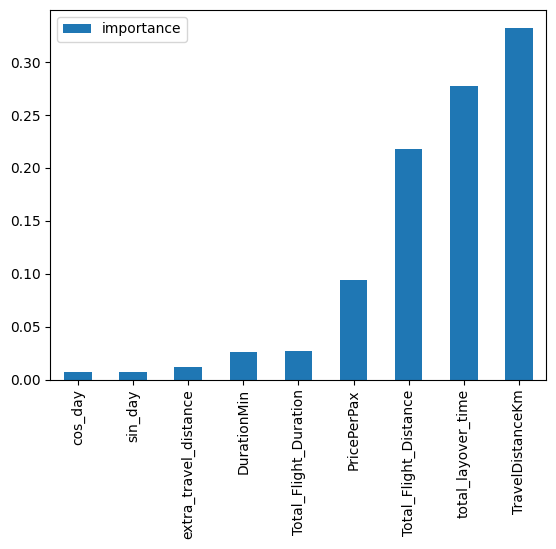

In [31]:
df.sort_values('importance').plot(kind='bar')

In [32]:
dohop_dropped_na = processed_dohop.dropna(subset=['TravelDistanceKm', 'Total_Flight_Distance'])

In [33]:
dohop_dropped_na.shape, clean_processed_data.drop('lod_od_by_itredirect', axis=1).shape

((595207, 10), (13405666, 9))

In [34]:
dohop_dropped_na.columns

Index(['TravelDistanceKm', 'DurationMin', 'Total_Flight_Distance',
       'Total_Flight_Duration', 'PricePerPax', 'total_layover_time',
       'extra_travel_distance', 'bookings', 'sin_day', 'cos_day'],
      dtype='object')

In [35]:
evaluate_model(dohop_dropped_na, forrest)

/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_14705/3781935284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["predicted_score"] = model.predict(data.drop('bookings', axis=1)).flatten()
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_14705/3781935284.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["status"] = np.where(data["bookings"] > 0, "booked", "not-booked")
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_14705/3781935284.py:23: UserWarning: Boolean

{'min_threshold': 4.185502636034341,
 'total_rows': 595207,
 'TP': 7082,
 'FP': 587532,
 'TN': 593,
 'FN': 0}

# Model results

### Results for Poisson Random Forrest with 60 trees, and 10 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.575537392470289,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587598,
- 'TN': 527,
- 'FN': 0

Training time - 15 minutes

### Results for Poisson Random Forrest with 150 trees, and 12 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.185502636034341,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587532,
- 'TN': 593,
- 'FN': 0

Training time - 27 minutes

### Results for Poisson Random Forrest with 80 trees, and 20 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 3.1303687347750593,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587909,
- 'TN': 216,
- 'FN': 0

Training time - 32 Minutes

### Results for Poisson Random Forrest with 80 trees, and 10 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.573138342576451,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587159,
- 'TN': 966,
- 'FN': 0

Training time - 19 Minutes

### Results for Poisson Random Forrest with 100 trees, and 8 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 5.302893033067785,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588104,
- 'TN': 21,
- 'FN': 0

Training time - 20 Minutes

### Results for Poisson Random Forrest with 100 trees, and 15 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 3.836471876184013,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587586,
- 'TN': 539,
- 'FN': 0

Training time - 33 Minutes

 ### Results for Poisson Random Forrest with 120 trees, and 10 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.672910392621909,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 586823,
- 'TN': 1302,
- 'FN': 0

Training time - 19 Minutes

 ### Results for Poisson Random Forrest with 200 trees, and 10 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.687645660979575,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587021,
- 'TN': 1104,
- 'FN': 0

Training time - 31 Minutes

### Results for Poisson Random Forrest with 10 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']


- 'min_threshold': 0.3559356535380518,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588118,
- 'TN': 7,
- 'FN': 0

Training time - 10 minutes

### Results for Poisson Random Forrest with 10 trees, and 25 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- min_threshold': 0.3980702486833349,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587975,
- 'TN': 150,
- 'FN': 0

Training time - 11 minutes

### Results for Poisson Random Forrest with 15 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.4278422656407467,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587982,
- 'TN': 143,
- 'FN': 0

Training time - 17 minutes

### Results for Poisson Random Forrest with 30 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- min_threshold': 0.3982078050924747,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588117,
- 'TN': 8,
- 'FN': 0

Training time - 27 minutes

### Results for Poisson Random Forrest with 5 trees, and 30 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.37001877943373246,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587691,
- 'TN': 434,
- 'FN': 0

Training time - 6 Minutes

#### Training on all data

- 'min_threshold': 0.33475150098093887,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588101,
- 'TN': 24,
- 'FN': 0

 Training time - 7 minutes

### Results for Poisson Random Forrest with 7 trees, and 40 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.3839483185231023,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587455,
- 'TN': 670,
- 'FN': 0

Training time - 9 minutes

#### Training on all data

- 'min_threshold': 0.3396465747051723,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588123,
- 'TN': 2,
- 'FN': 0

Training time - 11 minutes

### Results for Poisson Random Forrest with 10 trees, and 50 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.35784383270600656,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588114,
- 'TN': 11,
- 'FN': 0

Training time - 13 minutes

### Results for Poisson Random Forrest with 10 trees, and 30 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.38201788753136257,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588032,
- 'TN': 93,
- 'FN': 0

Training time - 13 minutes

### Results for Poisson Random Forrest with 15 trees, and 30 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.3933023326683685,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587957,
- 'TN': 168,
- 'FN': 0

Training time - 21 minutes


"Squared_error"
- min_threshold': 0.3944760162794704,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588066,
- 'TN': 59,
- 'FN': 0

### Results for Poisson Random Forrest with 15 trees, and 50 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.3929733733862467,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587980,
- 'TN': 145,
- 'FN': 0

Training time - 24 minutes
"squared_error"

- min_threshold': 0.39101792990309453,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588023,
- 'TN': 102,
- 'FN': 0

### Results for Poisson Random Forrest with 20 trees, and 30 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.40042538000947714,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588033,
- 'TN': 92,
- 'FN': 0

Training time - 29 minutes